# **Finetuning Embedding Model With Synthetic Data for Improving RAG**

## Install

In [ ]:
##
!pip install datasets==3.1.0
!pip install transformers==4.45.2 sentence-transformers==3.1.1
!pip install huggingface_hub["cli"]
##
!pip install langchain==0.3.9
##

!pip install -q fsspec==2024.10.0 unstructured["all-docs"]==0.16.8 pi_heif==0.20.0
!pip install --upgrade nltk
!pip install -q --user --upgrade pillow



In [2]:
import nltk
import os
from unstructured.partition.pdf import partition_pdf
from collections import Counter
import pickle

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [21]:
import wandb
wandb.init(mode="disabled")



## Set up the colab secrets with HUGGINGFACEHUB_API_TOKEN



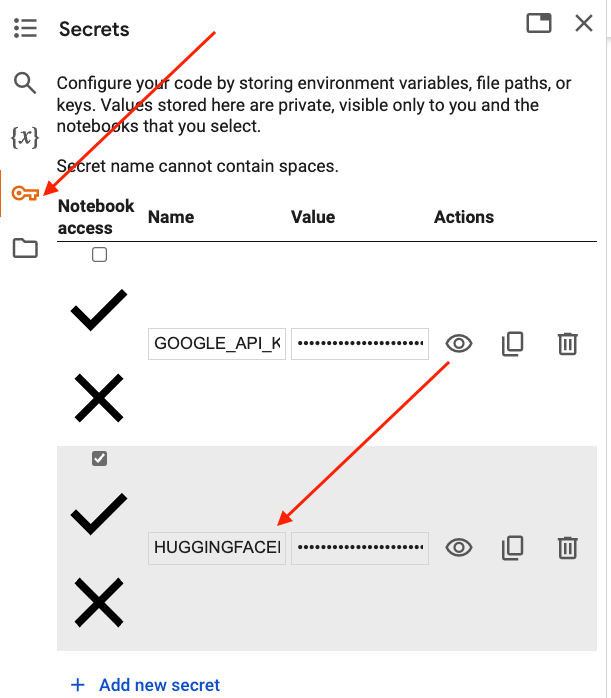

In [16]:
from google.colab import userdata
os.environ["HF_TOKEN"]  = userdata.get('HUGGINGFACEHUB_API_TOKEN')

# Process NVIDIA Corporation Annual Report pdf file

In [68]:
!mkdir -p data
!wget https://github.com/reza-rahim/published/raw/refs/heads/main/Fine_tuningEmbeddings/data/nasdaq-nvda-2024-10K-24660316.pdf -P data/

--2024-11-28 23:03:13--  https://github.com/reza-rahim/published/raw/refs/heads/main/Fine_tuningEmbeddings/data/nasdaq-nvda-2024-10K-24660316.pdf
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/reza-rahim/published/refs/heads/main/Fine_tuningEmbeddings/data/nasdaq-nvda-2024-10K-24660316.pdf [following]
--2024-11-28 23:03:14--  https://raw.githubusercontent.com/reza-rahim/published/refs/heads/main/Fine_tuningEmbeddings/data/nasdaq-nvda-2024-10K-24660316.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 947432 (925K) [application/octet-stream]
Saving to: ‘data/nasdaq-nvda-2024-10K-24660316.p

In [17]:
folder_path="data"
total_text = []
pdf_files = [f for f in os.listdir(folder_path) if f.endswith('.pdf')]
pdf_files

['nasdaq-nvda-2024-10K-24660316.pdf']

#### Read the text from the NVIDIA Corporation Annual Report 2024

In [5]:
for pdf_file in pdf_files:
        pdf_path = os.path.join(folder_path, pdf_file)
        print(f"Processing: {pdf_path}")

        # Apply the partition logic
        elements = partition_pdf(pdf_path, strategy="auto")

        # Display the types of elements
        display(Counter(type(element) for element in elements))

        # Join the elements to form text and add it to total_text list
        text = "\n\n".join([str(el) for el in elements])
        total_text.append(text)



Processing: data/nasdaq-nvda-2024-10K-24660316.pdf


Counter({unstructured.documents.elements.Text: 844,
         unstructured.documents.elements.Title: 614,
         unstructured.documents.elements.Header: 29,
         unstructured.documents.elements.NarrativeText: 702,
         unstructured.documents.elements.ListItem: 101})

In [ ]:
## Checkpoint
with open('data/total_text.pickle', 'wb') as f:
    pickle.dump(total_text, f)

In [ ]:
'''
with open('data/total_text.pickle', 'rb') as f:
  total_text = pickle.load(f)
'''

### Chunk the text with langchain text splitter

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=2048,
    chunk_overlap=100,
    length_function=len,
    is_separator_regex=False,
)
texts = text_splitter.create_documents([str(total_text)])

In [18]:
## Number of chunks
len(texts)

178

In [9]:
## Checkpoint
with open('data/texts.pickle', 'wb') as f:
    pickle.dump(texts, f)

In [ ]:
'''
with open('data/texts.pickle', 'rb') as f:
  _texts = pickle.load(f)

len(_texts)
'''

"\nwith open('data/texts.pickle', 'rb') as f:\n  _texts = pickle.load(f)\n\nlen(_texts)\n"

In [10]:
## sample chunk
texts[10].page_content

'In addition, generative AI is expanding the market for our workstation-class GPUs, as more enterprise customers develop and deploy AI applications with their data on-premises.\\n\\nHeadquartered in Santa Clara, California, NVIDIA was incorporated in California in April 1993 and reincorporated in Delaware in April 1998.\\n\\nOur Businesses\\n\\nWe report our business results in two segments.\\n\\nThe Compute & Networking segment is comprised of our Data Center accelerated computing platforms and end-to-end networking platforms including Quantum for InﬁniBand and Spectrum for Ethernet; our NVIDIA DRIVE automated-driving platform and automotive development agreements; Jetson robotics and other embedded platforms; NVIDIA AI Enterprise and other software; and DGX Cloud software and services.\\n\\nThe Graphics segment includes GeForce GPUs for gaming and PCs, the GeForce NOW game streaming service and related infrastructure; Quadro/NVIDIA RTX GPUs for enterprise workstation graphics; virtua

# Synthetic Dataset Generation
### The prompt function creates a prompt for huggingface Llama model,<br> requesting a Question-Answer pair based on a provided text chunk.

In [19]:
## the
import requests


def query_llm(query):
  url = "https://api-inference.huggingface.co/models/meta-llama/Meta-Llama-3-8B-Instruct"
  token = os.environ["HF_TOKEN"]
  parameters = {
        "max_new_tokens": 5000,
        "temperature": 0.01,
        "top_k": 50,
        "top_p": 0.95,
        "return_full_text": False
  }

  prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
          Based on the following text, generate one Question and its corresponding Answer. Please format the output as follows:
          Question: [Your question]
          Answer: [Your answer]
          <|eot_id|><|start_header_id|>user<|end_header_id|> Text:  ```{query}```.
        Provide precise and concise answer.<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""

  headers = {
        'Authorization': f'Bearer {token}',
        'Content-Type': 'application/json'
  }

  payload = {
        "inputs": prompt,
        "parameters": parameters
    }

  response = requests.post(url, headers=headers, json=payload)
  response_text = response.json()[0]['generated_text'].strip()
  return response_text


In [20]:
i=0
llm_qa_all =[]
for text in texts:
  i=i+1
  qa=query_llm(text.page_content)
  print(f"{i}: {qa}")
  llm_qa_all.append(qa)

1: Question: What is the publication date of the NVIDIA Corporation Annual Report 2024?
Answer: February 21st, 2024
2: Question: What is the filing date of the 10-K report for NVIDIA Corporation in 2004?
Answer: The filing dates of the 10-K reports for NVIDIA Corporation in 2004 are May 20th, March 29th, and April 25th.
3: Question: What is the purpose of the section of the filing that requires the registrant to indicate whether it has submitted electronically every Interactive Data File required to be submitted during the preceding 12 months?

Answer: The purpose of this section is to comply with Rule 405 of Regulation S-T, which requires the registrant to submit electronic files for certain financial information.
4: Question: What is the aggregate market value of the voting stock held by non-affiliates of the registrant as of July 28, 2023?

Answer: Approximately $1.1 trillion.
5: Question: Where can investors find more information about NVIDIA's financial information and company upd

In [22]:
## Checkpoint
with open('data/llm_qa_all.pickle', 'wb') as f:
    pickle.dump(llm_qa_all, f)

In [ ]:
'''
import pickle
with open('data/llm_qa_all.pickle', 'rb') as f:
  llm_qa_all = pickle.load(f)

len(llm_qa_all)
'''

178

### save the LLM generated data into csv file

In [24]:
results = []
for llm_qa in llm_qa_all:
  question, answer=llm_qa.split("Answer:")
  question = question.replace("Question: ", "").strip()
  results.append({"Question": question, "Answer": answer})
  #print(question.strip(),answer.strip())


In [25]:
import pandas as pd
df = pd.DataFrame(results)

In [26]:
df_results = pd.DataFrame(results)
df_results.to_csv("data/generated_qa_pairs.csv", index=False)

In [27]:
!head data/generated_qa_pairs.csv

Question,Answer
What is the publication date of the NVIDIA Corporation Annual Report 2024?," February 21st, 2024"
What is the filing date of the 10-K report for NVIDIA Corporation in 2004?," The filing dates of the 10-K reports for NVIDIA Corporation in 2004 are May 20th, March 29th, and April 25th."
What is the purpose of the section of the filing that requires the registrant to indicate whether it has submitted electronically every Interactive Data File required to be submitted during the preceding 12 months?," The purpose of this section is to comply with Rule 405 of Regulation S-T, which requires the registrant to submit electronic files for certain financial information."
"What is the aggregate market value of the voting stock held by non-affiliates of the registrant as of July 28, 2023?", Approximately $1.1 trillion.
Where can investors find more information about NVIDIA's financial information and company updates?," Investors can find more information on NVIDIA's investor relati

# Start Fine tune with SentenceTransformer

---



### Next, load the generated QA pairs from the CSV file into a HuggingFace dataset. We make sure the data is in the correct format for fine-tuning.

> Add blockquote



In [28]:
from datasets import load_dataset
dataset = load_dataset('csv', data_files='data/generated_qa_pairs.csv')

def process_example(example, idx):
    return {
        "id": idx,  # Add unique ID based on the index
        "anchor": example["Question"],
        "positive": example["Answer"]
    }
dataset = dataset.map(process_example,
                      with_indices=True ,
                      remove_columns=["Question", "Answer"])

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

### Load [BAAI/bge-base-en-v1.5](https://huggingface.co/BAAI/bge-base-en-v1.5) from huggingfac -- ( [BGE: One-Stop Retrieval Toolkit For Search and RAG ](https://github.com/FlagOpen/FlagEmbedding) )

In [23]:

import torch
from sentence_transformers import SentenceTransformer, SentenceTransformerTrainer, losses

model_id = "BAAI/bge-base-en-v1.5"

# Load a model
model = SentenceTransformer(
    model_id, device="cuda" if torch.cuda.is_available() else "cpu"
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


 ### Create an  [InformationRetrievalEvaluator](https://sbert.net/docs/package_reference/sentence_transformer/evaluation.html#informationretrievalevaluator) evaluator to measure the model’s performance during training. The evaluator assesses the model’s retrieval performance using InformationRetrievalEvaluator.



In [31]:
from sentence_transformers.evaluation import ( SequentialEvaluator , InformationRetrievalEvaluator)

corpus = dict(zip(dataset["train"]["id"], dataset["train"]["anchor"]))
queries = dict(zip(dataset["train"]["id"], dataset["train"]["positive"]))

relevant_docs = {}  #

for q_id in queries:
    relevant_docs[q_id] = [q_id]


evaluator = InformationRetrievalEvaluator(
    queries=queries,
    corpus=corpus,
    relevant_docs=relevant_docs,
    name="bge-base-en",
)
base_results = evaluator(model)


In [30]:
base_results
#'bge-base-en_dot_ndcg@10': 0.5949908809486526,

{'bge-base-en_cosine_accuracy@1': 0.4606741573033708,
 'bge-base-en_cosine_accuracy@3': 0.601123595505618,
 'bge-base-en_cosine_accuracy@5': 0.6685393258426966,
 'bge-base-en_cosine_accuracy@10': 0.7415730337078652,
 'bge-base-en_cosine_precision@1': 0.4606741573033708,
 'bge-base-en_cosine_precision@3': 0.20037453183520593,
 'bge-base-en_cosine_precision@5': 0.1337078651685393,
 'bge-base-en_cosine_precision@10': 0.0741573033707865,
 'bge-base-en_cosine_recall@1': 0.4606741573033708,
 'bge-base-en_cosine_recall@3': 0.601123595505618,
 'bge-base-en_cosine_recall@5': 0.6685393258426966,
 'bge-base-en_cosine_recall@10': 0.7415730337078652,
 'bge-base-en_cosine_ndcg@10': 0.5949908809486526,
 'bge-base-en_cosine_mrr@10': 0.5487560192616373,
 'bge-base-en_cosine_map@100': 0.5588326293039799,
 'bge-base-en_dot_accuracy@1': 0.4606741573033708,
 'bge-base-en_dot_accuracy@3': 0.601123595505618,
 'bge-base-en_dot_accuracy@5': 0.6685393258426966,
 'bge-base-en_dot_accuracy@10': 0.7415730337078652

The loss function, [MultipleNegativesRankingLoss](https://www.sbert.net/docs/package_reference/sentence_transformer/losses.html#multiplenegativesrankingloss), helps the model produce embeddings suitable for retrieval tasks

In [32]:
loss = losses.MultipleNegativesRankingLoss(model)

Use SentenceTransformerTrainingArguments to define the training parameters. This includes the
- output directory,
- number of epochs,
- batch size,
- learning rate,
-  evaluation strategy.

metric_for_best_model="bge-base-en_dot_ndcg@10",  # Optimizing for the best ndcg@10 score for the 128 dimension

In [34]:
from sentence_transformers import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
args = SentenceTransformerTrainingArguments(
    output_dir="bge-finetuned",                 # output directory and hugging face model ID
    num_train_epochs=25,                         # number of epochs
    per_device_train_batch_size=4,              # train batch size
    gradient_accumulation_steps=16,             # for a global batch size of 512
    per_device_eval_batch_size=16,              # evaluation batch size
    warmup_ratio=0.1,                           # warmup ratio
    learning_rate=2e-5,                         # learning rate, 2e-5 is a good value
    lr_scheduler_type="cosine",                 # use constant learning rate scheduler
    optim="adamw_torch_fused",                  # use fused adamw optimizer
    #tf32=True,                                  # use tf32 precision
    #bf16=True,                                  # use bf16 precision
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
    eval_strategy="epoch",                      # evaluate after each epoch
    save_strategy="epoch",                      # save after each epoch
    logging_steps=10,                           # log every 10 steps
    save_total_limit=3,                         # save only the last 3 models
    load_best_model_at_end=True,                # load the best model when training ends
    metric_for_best_model="bge-base-en_dot_ndcg@10",  # Optimizing for the best ndcg@10 score for the 128 dimension
)

 Create a SentenceTransformerTrainer object, specifying the model, training arguments, dataset, loss function, and evaluator

In [35]:
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=dataset.select_columns(
        ["anchor","positive"]
    ),
    loss=loss,
    evaluator=evaluator,
)



### Starting Fine-tuning
The trainer.train() method starts the fine-tuning process, updating the model's weights using the provided data and loss function.

In [36]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Bge-base-en Cosine Accuracy@1,Bge-base-en Cosine Accuracy@3,Bge-base-en Cosine Accuracy@5,Bge-base-en Cosine Accuracy@10,Bge-base-en Cosine Precision@1,Bge-base-en Cosine Precision@3,Bge-base-en Cosine Precision@5,Bge-base-en Cosine Precision@10,Bge-base-en Cosine Recall@1,Bge-base-en Cosine Recall@3,Bge-base-en Cosine Recall@5,Bge-base-en Cosine Recall@10,Bge-base-en Cosine Ndcg@10,Bge-base-en Cosine Mrr@10,Bge-base-en Cosine Map@100,Bge-base-en Dot Accuracy@1,Bge-base-en Dot Accuracy@3,Bge-base-en Dot Accuracy@5,Bge-base-en Dot Accuracy@10,Bge-base-en Dot Precision@1,Bge-base-en Dot Precision@3,Bge-base-en Dot Precision@5,Bge-base-en Dot Precision@10,Bge-base-en Dot Recall@1,Bge-base-en Dot Recall@3,Bge-base-en Dot Recall@5,Bge-base-en Dot Recall@10,Bge-base-en Dot Ndcg@10,Bge-base-en Dot Mrr@10,Bge-base-en Dot Map@100
0,No log,No log,0.460674,0.601124,0.668539,0.752809,0.460674,0.200375,0.133708,0.075281,0.460674,0.601124,0.668539,0.752809,0.599561,0.551418,0.560864,0.460674,0.601124,0.668539,0.752809,0.460674,0.200375,0.133708,0.075281,0.460674,0.601124,0.668539,0.752809,0.599561,0.551418,0.560864
1,No log,No log,0.483146,0.657303,0.707865,0.764045,0.483146,0.219101,0.141573,0.076404,0.483146,0.657303,0.707865,0.764045,0.623534,0.578384,0.588873,0.483146,0.657303,0.707865,0.764045,0.483146,0.219101,0.141573,0.076404,0.483146,0.657303,0.707865,0.764045,0.623534,0.578384,0.588873
2,No log,No log,0.516854,0.679775,0.719101,0.792135,0.516854,0.226592,0.143820,0.079213,0.516854,0.679775,0.719101,0.792135,0.652664,0.608229,0.619101,0.516854,0.679775,0.719101,0.792135,0.516854,0.226592,0.143820,0.079213,0.516854,0.679775,0.719101,0.792135,0.652664,0.608229,0.619101
3,0.749000,No log,0.589888,0.696629,0.775281,0.848315,0.589888,0.232210,0.155056,0.084831,0.589888,0.696629,0.775281,0.848315,0.705717,0.661733,0.670390,0.589888,0.696629,0.775281,0.848315,0.589888,0.232210,0.155056,0.084831,0.589888,0.696629,0.775281,0.848315,0.705717,0.661733,0.670390
4,0.749000,No log,0.612360,0.735955,0.808989,0.865169,0.612360,0.245318,0.161798,0.086517,0.612360,0.735955,0.808989,0.865169,0.734044,0.692309,0.700889,0.612360,0.735955,0.808989,0.865169,0.612360,0.245318,0.161798,0.086517,0.612360,0.735955,0.808989,0.865169,0.734044,0.692309,0.700889
5,0.749000,No log,0.623596,0.764045,0.837079,0.898876,0.623596,0.254682,0.167416,0.089888,0.623596,0.764045,0.837079,0.898876,0.755455,0.710010,0.715794,0.623596,0.764045,0.837079,0.898876,0.623596,0.254682,0.167416,0.089888,0.623596,0.764045,0.837079,0.898876,0.755455,0.710010,0.715794
6,0.749000,No log,0.657303,0.792135,0.853933,0.893258,0.657303,0.264045,0.170787,0.089326,0.657303,0.792135,0.853933,0.893258,0.776508,0.738831,0.745355,0.657303,0.792135,0.853933,0.893258,0.657303,0.264045,0.170787,0.089326,0.657303,0.792135,0.853933,0.893258,0.776508,0.738831,0.745355
7,0.363000,No log,0.679775,0.808989,0.870787,0.898876,0.679775,0.269663,0.174157,0.089888,0.679775,0.808989,0.870787,0.898876,0.791889,0.757254,0.763304,0.679775,0.808989,0.870787,0.898876,0.679775,0.269663,0.174157,0.089888,0.679775,0.808989,0.870787,0.898876,0.791889,0.757254,0.763304
8,0.363000,No log,0.691011,0.808989,0.876404,0.904494,0.691011,0.269663,0.175281,0.090449,0.691011,0.808989,0.876404,0.904494,0.796928,0.762522,0.768489,0.691011,0.808989,0.876404,0.904494,0.691011,0.269663,0.175281,0.090449,0.691011,0.808989,0.876404,0.904494,0.796928,0.762522,0.768489
9,0.363000,No log,0.713483,0.820225,0.876404,0.915730,0.713483,0.273408,0.175281,0.091573,0.713483,0.820225,0.876404,0.915730,0.809792,0.776380,0.781615,0.713483,0.820225,0.876404,0.915730,0.713483,0.273408,0.175281,0.091573,0.713483,0.820225,0.876404,0.915730,0.809792,0.776380,0.781615


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

TrainOutput(global_step=50, training_loss=0.3233694338798523, metrics={'train_runtime': 273.9435, 'train_samples_per_second': 16.244, 'train_steps_per_second': 0.183, 'total_flos': 0.0, 'train_loss': 0.3233694338798523, 'epoch': 17.77777777777778})

In [37]:
# save the best model
trainer.save_model()

In [60]:
#reload the model from disk
fine_tuned_model = SentenceTransformer(
    args.output_dir, device="cuda" if torch.cuda.is_available() else "cpu"
)

In [40]:
evaluator(fine_tuned_model)
#bge-base-en_dot_ndcg@10': 0.8245911858212284,

{'bge-base-en_cosine_accuracy@1': 0.7303370786516854,
 'bge-base-en_cosine_accuracy@3': 0.8314606741573034,
 'bge-base-en_cosine_accuracy@5': 0.8876404494382022,
 'bge-base-en_cosine_accuracy@10': 0.9269662921348315,
 'bge-base-en_cosine_precision@1': 0.7303370786516854,
 'bge-base-en_cosine_precision@3': 0.2771535580524344,
 'bge-base-en_cosine_precision@5': 0.1775280898876404,
 'bge-base-en_cosine_precision@10': 0.09269662921348312,
 'bge-base-en_cosine_recall@1': 0.7303370786516854,
 'bge-base-en_cosine_recall@3': 0.8314606741573034,
 'bge-base-en_cosine_recall@5': 0.8876404494382022,
 'bge-base-en_cosine_recall@10': 0.9269662921348315,
 'bge-base-en_cosine_ndcg@10': 0.8245911858212284,
 'bge-base-en_cosine_mrr@10': 0.7921950240770463,
 'bge-base-en_cosine_map@100': 0.797491792209672,
 'bge-base-en_dot_accuracy@1': 0.7303370786516854,
 'bge-base-en_dot_accuracy@3': 0.8314606741573034,
 'bge-base-en_dot_accuracy@5': 0.8876404494382022,
 'bge-base-en_dot_accuracy@10': 0.92696629213483

## Test some text from training data

In [41]:
sentences = ["Question: What is the purpose of recognizing a valuation allowance to reduce deferred tax assets?",
"To reduce any deferred tax assets by the amount of any tax benefits that, based on available evidence and judgment, are not expected to be realized.",
"What is the carrying value of NVIDIA Corporation's outstanding notes as of January 28, 2024?"]


In [44]:
## reload the base mode

model_id = "BAAI/bge-base-en-v1.5"

# Load a model
model = SentenceTransformer(
    model_id, device="cuda" if torch.cuda.is_available() else "cpu"
)

In [45]:
#check cosine similarities with base model
embeddings = model.encode(sentences)
print(embeddings.shape)
similarities = model.similarity(embeddings, embeddings)
print(similarities)

(3, 768)
tensor([[1.0000, 0.6696, 0.5513],
        [0.6696, 1.0000, 0.4013],
        [0.5513, 0.4013, 1.0000]])


In [61]:
#check cosine similarities with fine tune model
embeddings = fine_tuned_model.encode(sentences)
print(embeddings.shape)
similarities = fine_tuned_model.similarity(embeddings, embeddings)
print(similarities)

(3, 768)
tensor([[1.0000, 0.6523, 0.3671],
        [0.6523, 1.0000, 0.2324],
        [0.3671, 0.2324, 1.0000]])


### push the finetuned model to hub

> Add blockquote



In [63]:
fine_tuned_model.push_to_hub("rezarahim/bge-finetuned")

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

'https://huggingface.co/rezarahim/bge-finetuned/commit/710ab997143213e08181e0e3141ce494f3f70671'

### reload the finetuned model to hub

In [64]:
fine_tuned_model = "rezarahim/bge-finetuned"

# Load a model
fine_tuned_model = SentenceTransformer(
    fine_tuned_model, device="cuda" if torch.cuda.is_available() else "cpu"
)

README.md:   0%|          | 0.00/27.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

In [65]:
#check cosine similarities with fine tune model
embeddings = fine_tuned_model.encode(sentences)
print(embeddings.shape)
similarities = fine_tuned_model.similarity(embeddings, embeddings)
print(similarities)

(3, 768)
tensor([[1.0000, 0.6523, 0.3671],
        [0.6523, 1.0000, 0.2324],
        [0.3671, 0.2324, 1.0000]])
